# Retail Data Wrangling and Analytics

In [1]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import psycopg2
from sqlalchemy import create_engine

In [2]:
#install psql "driver"
!pip3 install psycopg2-binary

In [3]:
engine_string = 'postgresql+psycopg2://postgres:@127.0.0.1'
engine = create_engine(engine_string,pool_recycle=3600)

# Connect to POstgresSQL server
dbConnection = engine.connect()

In [4]:
# Read data from the table
retail_df = pd.read_sql_table("retail",dbConnection)
retail_df.head()
dbConnection.close()

In [5]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice_no    1067371 non-null  object        
 1   stock_code    1067371 non-null  object        
 2   description   1062989 non-null  object        
 3   quantity      1067371 non-null  int64         
 4   invoice_date  1067371 non-null  datetime64[ns]
 5   unit_price    1067371 non-null  float64       
 6   customer_id   824364 non-null   float64       
 7   country       1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [6]:
retail_df.describe()

,quantity,invoice_date,unit_price,customer_id
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028800,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


# Total Invoice Amount Distribution

            invoice_amount
invoice_no                
489434              505.30
489435              145.80
489436              630.33
489437              310.75
489438             2286.24
...                    ...
581583              124.60
581584              140.64
581585              329.05
581586              339.20
581587              267.45

[45330 rows x 1 columns]
       invoice_amount
count    45330.000000
mean       462.420748
std       1435.680798
min          0.000000
25%        104.650000
50%        263.585000
75%        459.687500
max     168469.600000


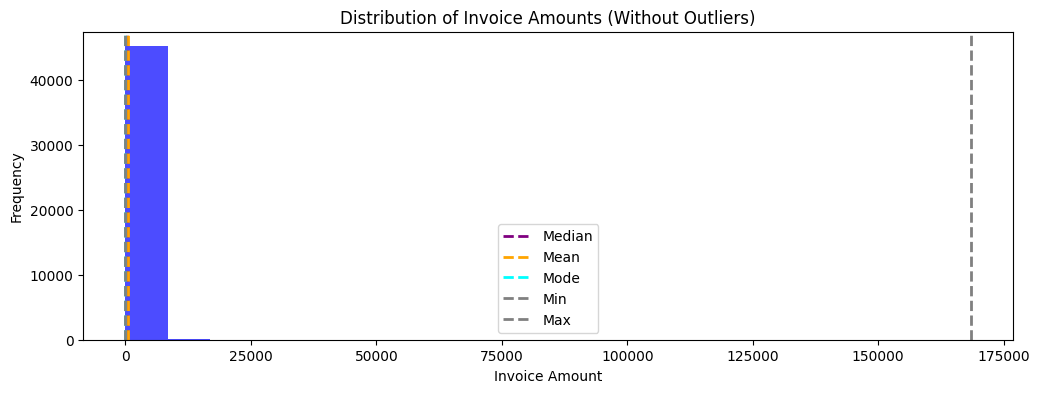

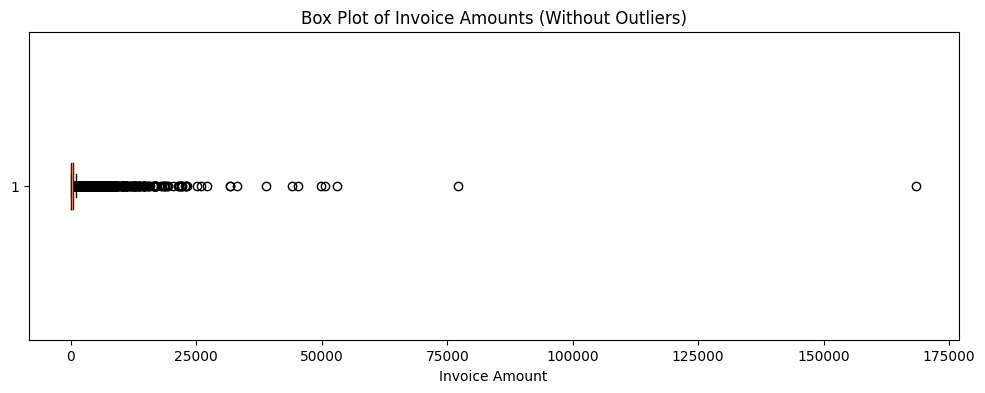

       invoice_amount
count    38530.000000
mean       226.023716
std        177.278672
min          0.000000
25%         70.830000
50%        206.700000
75%        344.870000
max        662.390000


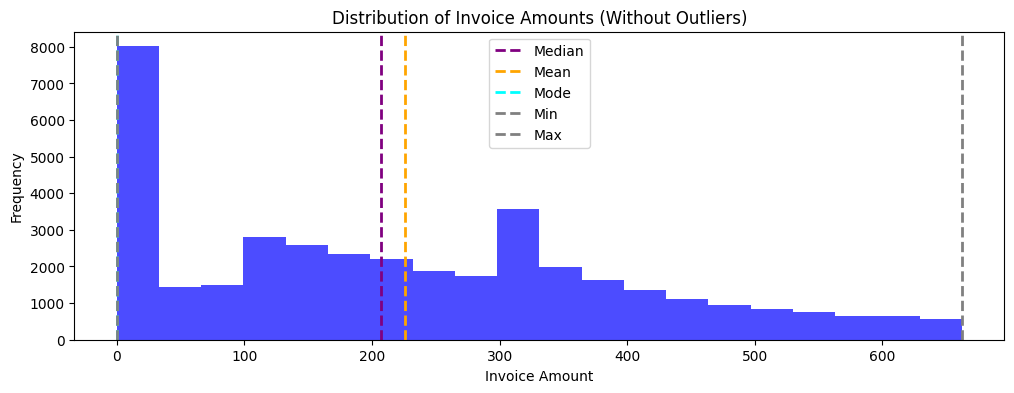

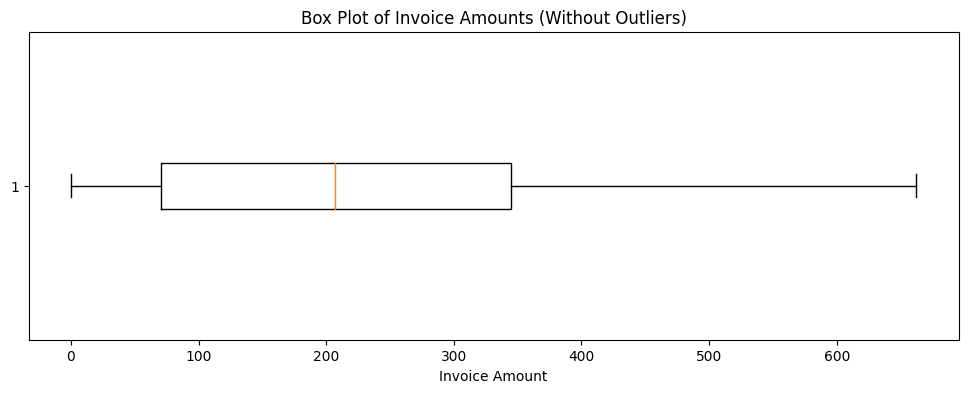

In [21]:
# 1. Calculate invoice amount

invoice_df = retail_df.loc[retail_df["invoice_no"].str.isnumeric()].reset_index()
invoice_df['invoice_amount'] = invoice_df['quantity'] * invoice_df['unit_price']
invoice_amount_df=invoice_df[["invoice_no", "invoice_amount"]].groupby("invoice_no").sum()
print(invoice_amount_df)

# 2. Draw the distribution of invoice amount with min, max, median, mod, and mean.

def show_distribution(data_frame):

    # Calculate summary statistics

    min_val = data_frame['invoice_amount'].min()
    max_val = data_frame['invoice_amount'].max()
    mean_val = data_frame['invoice_amount'].mean()
    med_val = data_frame['invoice_amount'].median()
    mod_val = data_frame['invoice_amount'].mode()[0]

    # Create histogram
    plt.figure(figsize=(12, 4))
    plt.hist(data_frame['invoice_amount'], bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Invoice Amounts (Without Outliers)')
    plt.xlabel('Invoice Amount')
    plt.ylabel('Frequency')

    # Add vertical lines for summary statistics
    plt.axvline(x=med_val, color='purple', linestyle='dashed', linewidth=2, label='Median')
    plt.axvline(x=mean_val, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(x=mod_val, color='cyan', linestyle='dashed', linewidth=2, label='Mode')
    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Min')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Max')

    plt.legend()
    plt.show()


    # Create box plot
    plt.figure(figsize=(12, 4))
    plt.boxplot(data_frame['invoice_amount'], vert=False)
    plt.title('Box Plot of Invoice Amounts (Without Outliers)')
    plt.xlabel('Invoice Amount')

    plt.show()

# Call the function to analyze and visualize invoice amounts
show_distribution(invoice_amount_df)


#3. Draw the distribution for the first 85 quantiles of the invoice amount data with min, max, median, mod, and mean.

df2 = invoice_amount_df[invoice_amount_df['invoice_amount'] <= invoice_amount_df['invoice_amount'].quantile(0.85)]
show_distribution(df2)


# Monthly Placed and Canceled Orders

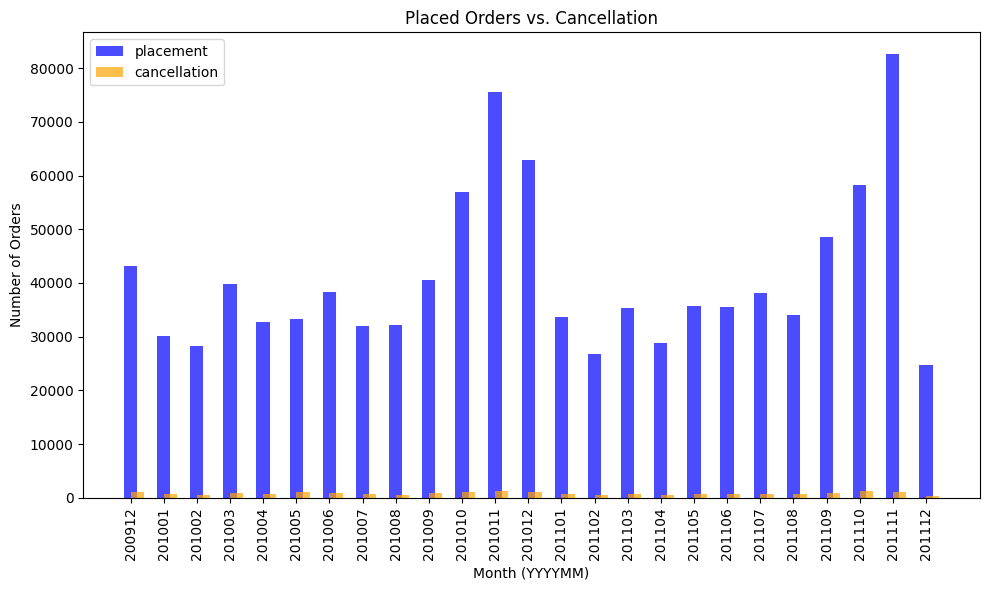

In [8]:
# Calculate the YYYYMM format column for grouping
retail_df['invoice_month'] = pd.to_datetime(retail_df['invoice_date']).dt.strftime('%Y%m')

# Identify canceled orders
canceled_orders = retail_df[retail_df['invoice_no'].str.startswith('C')]

# Calculate the number of placed orders per month
total_orders_per_month = retail_df.groupby('invoice_month')['invoice_no'].count()
canceled_orders_per_month = canceled_orders.groupby('invoice_month')['invoice_no'].count()

# Adjust the number of placed orders based on canceled orders
adjusted_orders_per_month = total_orders_per_month - 2 * canceled_orders_per_month

# df=pd.concat([adjusted_orders_per_month, canceled_orders_per_month], axis=1)
# df.plot(x='invoice_month', y=['placement', 'cancellation'], kind='bar', figsize=(15,10))

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.4
plt.bar(total_orders_per_month.index, adjusted_orders_per_month, label='placement', width=bar_width, color='blue', alpha=0.7)
plt.bar(total_orders_per_month.index, canceled_orders_per_month, label='cancellation', width=bar_width, color='orange', alpha=0.7, align='edge')
plt.title('Placed Orders vs. Cancellation')
plt.xlabel('Month (YYYYMM)')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



# Monthly Sales

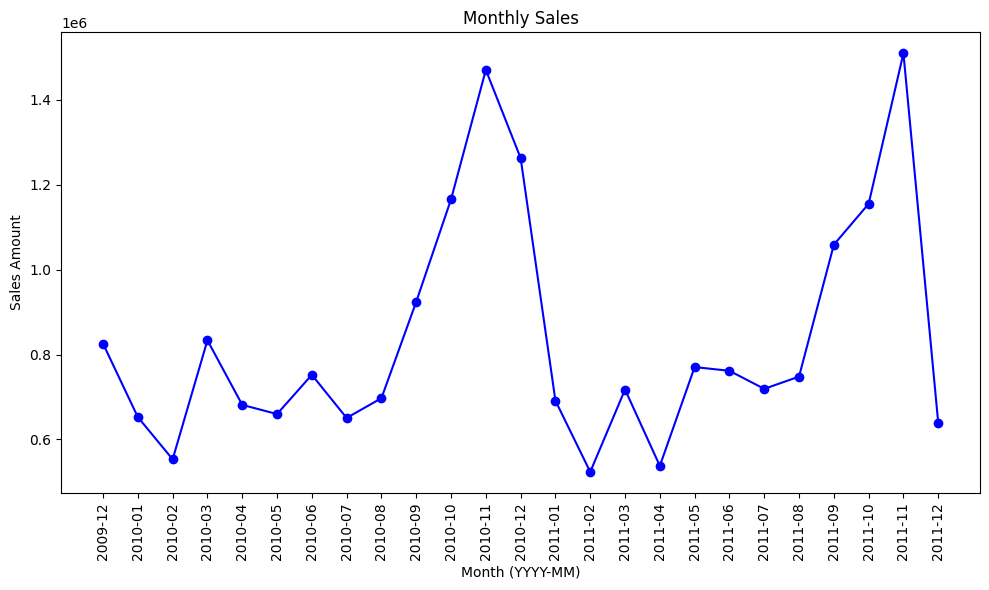

In [9]:
# Calculate the YYYY-MM format column for grouping
retail_df['invoice_month'] = pd.to_datetime(retail_df['invoice_date']).dt.to_period('M')

sales_df=retail_df.loc[retail_df["invoice_no"].str.isnumeric()].reset_index()
sales_df['invoice_amount'] = sales_df['quantity'] * sales_df['unit_price']

# Calculate the monthly sales data
monthly_sales = sales_df.groupby('invoice_month')['invoice_amount'].sum()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index.strftime('%Y-%m'), monthly_sales.values, marker='o', color='blue')
plt.title('Monthly Sales')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Sales Amount')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Monthly Sales Growth


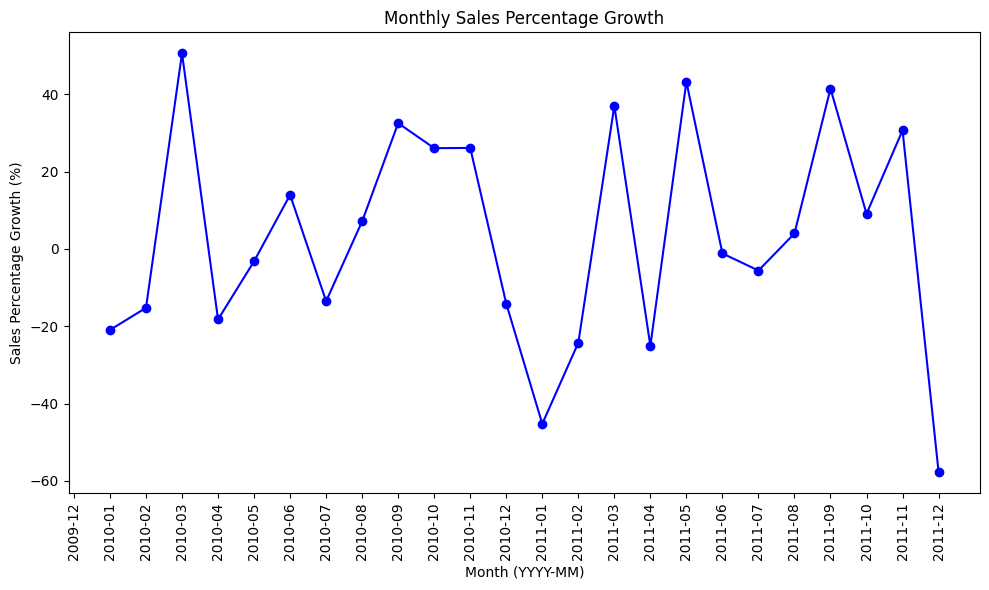

In [10]:
# Calculate the monthly sales data
monthly_sales = sales_df.groupby('invoice_month')['invoice_amount'].sum()

# Calculate the monthly sales percentage growth data
monthly_sales_growth = monthly_sales.pct_change() * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales_growth.index.strftime('%Y-%m'), monthly_sales_growth.values, marker='o', color='blue')
plt.title('Monthly Sales Percentage Growth')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Sales Percentage Growth (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Monthly Active Users

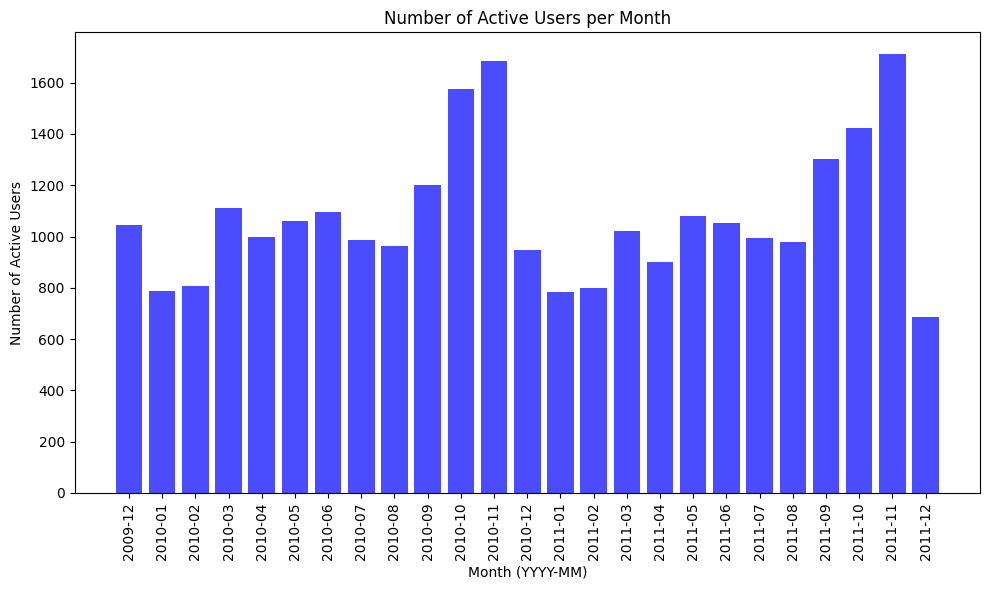

In [11]:
# Compute the number of active users (unique CustomerID) for each month
active_users_per_month = retail_df.groupby('invoice_month')['customer_id'].nunique()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(active_users_per_month.index.strftime('%Y-%m'), active_users_per_month.values, color='blue', alpha=0.7)
plt.title('Number of Active Users per Month')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Number of Active Users')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# New and Existing Users



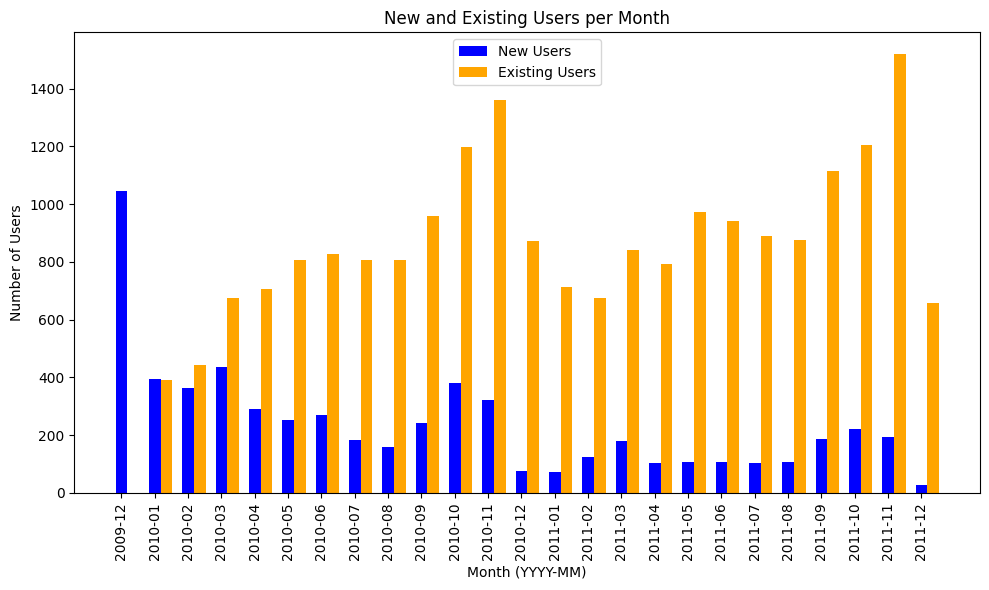

In [12]:
df = retail_df

# Find the first purchase year-month for each user
first_purchase = df.groupby('customer_id')['invoice_month'].min()

# Merge the first purchase data with the main data
df = df.merge(first_purchase, left_on='customer_id', right_index=True, suffixes=('', '_first'))

# Identify new and existing users
df['user_type'] = 'Existing'
df.loc[df['invoice_month'] == df['invoice_month_first'], 'user_type'] = 'New'

# Calculate the number of new and existing users for each month
user_types_per_month = df.groupby(['invoice_month', 'user_type'])['customer_id'].nunique().unstack()

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = user_types_per_month.index.strftime('%Y-%m')
new_users = user_types_per_month['New']
existing_users = user_types_per_month['Existing']
plt.bar(index, new_users, color='blue', label='New Users', width=bar_width)
plt.bar([i + bar_width for i in range(len(index))], existing_users, color='orange', label='Existing Users', width=bar_width)
plt.title('New and Existing Users per Month')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Number of Users')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

## Finding RFM

In [13]:
df = retail_df

# Calculate Recency, Frequency, and Monetary Value for each customer
rfm_data = df.groupby('customer_id').agg({
    'invoice_date': 'max',               # Recency
    'invoice_no': 'nunique',             # Frequency
    'unit_price': 'sum'                  # Monetary Value
})

# Rename columns for better understanding
rfm_data.rename(columns={
    'invoice_date': 'Recency',
    'invoice_no': 'Frequency',
    'unit_price': 'MonetaryValue'
}, inplace=True)

# Calculate Recency in days
max_date = df['invoice_date'].max()
rfm_data['Recency'] = (max_date - rfm_data['Recency']).dt.days

# Create bins or segments for Recency, Frequency, and Monetary Value
quantiles = rfm_data.quantile(q=[0.25, 0.5, 0.75])
rfm_segments = rfm_data.copy()
rfm_segments['RecencyScore'] = pd.cut(rfm_segments['Recency'], bins=[-1, quantiles['Recency'][0.25], quantiles['Recency'][0.5], quantiles['Recency'][0.75], rfm_segments['Recency'].max()+1], labels=['4', '3', '2', '1'])
rfm_segments['FrequencyScore'] = pd.cut(rfm_segments['Frequency'], bins=[1, quantiles['Frequency'][0.25], quantiles['Frequency'][0.5], quantiles['Frequency'][0.75], rfm_segments['Frequency'].max()], labels=['1', '2', '3', '4'])
rfm_segments['MonetaryScore'] = pd.cut(rfm_segments['MonetaryValue'], bins=[-1, quantiles['MonetaryValue'][0.25], quantiles['MonetaryValue'][0.5], quantiles['MonetaryValue'][0.75], rfm_segments['MonetaryValue'].max()+1], labels=['4', '3', '2', '1'])

# Calculate RFM Score
rfm_segments['RFM_Score'] = rfm_segments['RecencyScore'].astype(str) + rfm_segments['FrequencyScore'].astype(str) + rfm_segments['MonetaryScore'].astype(str)

# Analyze the results
rfm_segments.head(4)


,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
customer_id,,,,,,,
12346.0,325,17,580.44,2,4,1,241
12347.0,1,8,644.16,4,3,1,431
12348.0,74,5,193.10,3,3,2,332
12349.0,18,5,1504.59,4,3,1,431


# RFM Segmentation

In [14]:
# Segmenting customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [15]:
rfm_segments['Segment'] = rfm_segments['RecencyScore'].astype(str) + rfm_segments['FrequencyScore'].astype(str)
rfm_segments['Segment'] = rfm_segments['Segment'].replace(seg_map, regex=True)

df=rfm_segments[["Segment", "Recency","Frequency","MonetaryValue"]].groupby("Segment").agg(["mean","count"])
df = df[df.index.str.contains('nan') == False]

df.head(10)

Recency        Frequency       MonetaryValue      
                           mean count       mean count          mean count
Segment                                                                   
About to Sleep        53.860515   466   2.903433   466    188.249122   466
At Risk              268.001473   679   9.212077   679    738.022804   679
Hibernating          355.281385  1155   2.714286  1155    201.891058  1155
Loyal Customers       23.921300  1169  23.542344  1169   1472.413428  1169
Need Attention        54.136646   322   6.229814   322    382.261866   322
Potential Loyalists   11.394316   563   5.134991   563    348.167444   563
Promising             11.724409   127   2.000000   127    137.852598   127